In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.68 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA tha

In [5]:
print(ds_train)


<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))
#두개 더하면 23262로 잘 나눠졌다

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니므로 ds_train.shape 같은 게 존재하지 않습니다. 위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 등 가장 중요한 정보들이 잘 확인되었나요?
### 2) Input Normalization

    딥러닝 용어 정리, Normalization(정규화) 설명

우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있는데요. 이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현합니다. RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법이죠. 그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지입니다. RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있습니다.

우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224]) #밑의 요청대로 224,224,3으로 리사이즈
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features["label"].num_classes

2

In [10]:
ds_info.features["label"].names

['cat', 'dog']

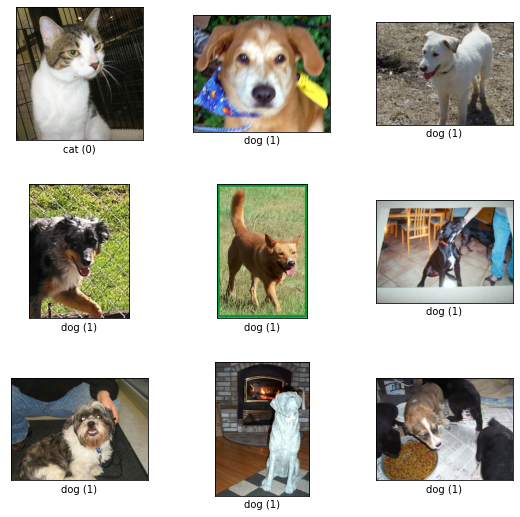

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

In [12]:
BATCH_SIZE = 16
EPOCH = 10

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)


## 2-7. 프로젝트: ResNet Ablation Study
#### 1) ResNet 기본 블록 구성하기

이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. Learning by Doing 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.

우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇 번의 경험이 있습니다.
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.

그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.

하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현 방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다. 

![image](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

[resnet paper](http://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

![image](https://user-images.githubusercontent.com/81237366/145163030-41f783d9-52a9-4094-8a38-eb2e19cf6909.png)

![image](https://user-images.githubusercontent.com/81237366/145165381-23b6e880-d865-40da-93b1-9de7204cfe5a.png)

In [13]:
#레즈넷 공통인 위쪽부분 구현
def start_block(x):
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2,2),
        padding='same', 
        name='conv2d_7x7'
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)        

    x = keras.layers.MaxPooling2D(
             pool_size=(3, 3), 
             strides=2,
             name='stage2_0_maxpooling',
             padding='same'
            )(x)
    
    return x

In [14]:
def residual_block(x, filters_in,  k_size=3, stage_num=0,block_num=0,
                   is_shortcut=False, is_50=False, is_plain=False):
    shortcut = x

    if is_50:#레즈넷 50
        if is_shortcut: #숏컷
            x = tf.keras.layers.Conv2D(filters_in, kernel_size=(1, 1), strides=(2, 2), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{1}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{1}')(x)
            x = tf.keras.layers.Activation('relu')(x)

            x = tf.keras.layers.Conv2D(filters_in, kernel_size=(k_size, k_size), strides=(1, 1), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{2}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{2}')(x)
            x = tf.keras.layers.Activation('relu')(x)    

            x = tf.keras.layers.Conv2D(filters_in*4, kernel_size=(1, 1), strides=(1, 1), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{3}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{3}')(x)
            
            shortcut = tf.keras.layers.Conv2D(filters_in*4, kernel_size=(1, 1), strides=(2, 2), kernel_initializer='he_normal', 
                                              name=f'stage{stage_num}_{block_num}_short', padding="same")(shortcut)
            shortcut = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{4}')(shortcut)
        else :#숏컷아닐때
            x = tf.keras.layers.Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{1}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{1}')(x)
            x = tf.keras.layers.Activation('relu')(x)

            x = tf.keras.layers.Conv2D(filters_in, kernel_size=(k_size, k_size), strides=(1, 1), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{2}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{2}')(x)
            x = tf.keras.layers.Activation('relu')(x)    

            x = tf.keras.layers.Conv2D(filters_in*4, kernel_size=(1, 1), strides=(1, 1), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{3}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{3}')(x)
            if stage_num==2 and block_num==1:
                shortcut = tf.keras.layers.Conv2D(filters_in*4, kernel_size=(1, 1), strides=(1, 1), kernel_initializer='he_normal', 
                                              name=f'stage{stage_num}_{block_num}_short', padding="same")(shortcut)
                shortcut = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{4}')(shortcut)
                
        
        
    else:#레즈넷 34
        if is_shortcut: #제일 앞의 콘볼루션과 숏컷의 스트라이드를 2로준다 (layer.add부분의 필터수를 맞춰줘야하기 떄문)
            x = tf.keras.layers.Conv2D(filters_in, kernel_size=(k_size, k_size), strides=(2, 2), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{1}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{1}')(x)
            x = tf.keras.layers.Activation('relu')(x)    

            shortcut = tf.keras.layers.Conv2D(filters_in, kernel_size=(1, 1), strides=(2, 2), kernel_initializer='he_normal', 
                                              name=f'stage{stage_num}_{block_num}_short', padding="same")(shortcut)
            x = tf.keras.layers.Conv2D(filters_in, kernel_size=(k_size, k_size), strides=(1, 1), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{2}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{2}')(x)
            
            shortcut = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{4}')(shortcut)
            

            
        else :
            x = tf.keras.layers.Conv2D(filters_in, kernel_size=(k_size, k_size), strides=(1, 1), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{1}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{1}')(x)
            x = tf.keras.layers.Activation('relu')(x)    

            x = tf.keras.layers.Conv2D(filters_in, kernel_size=(k_size, k_size), strides=(1, 1), kernel_initializer='he_normal', 
                                       name=f'stage{stage_num}_{block_num}_conv{2}', padding="same")(x)
            x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num}_bn{2}')(x)
            
    if is_plain == False: #plain시 꺼짐
        x = tf.keras.layers.Add()([x, shortcut])
        
    return tf.keras.layers.Activation('relu')(x)

In [15]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=1,
                 k_size=3,
                 is_50=False,
                 is_plain=False
                ): #기존 lms에서 주어진 형태를 살리고 추가 변수를 넣어줬다
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    x = input_layer
    
    x = start_block(x)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for idx, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        for i in range(num_cnn):
            if i == 0 and channel != 64: #2스테이지 처음부분에서 숏컷이 적용안되도록 조절하면서 스테이지 처음 블럭에 숏컷
                x = residual_block(x,
                                   filters_in=channel,
                                   stage_num=idx+2, #2스테이지부터 시작하기 때문에
                                   block_num=i+1, #블럭도 1부터 시작한다
                                   k_size=3,
                                   is_shortcut=True,
                                   is_50=is_50,
                                   is_plain=is_plain
                                  )
    
            else:
                x = residual_block(x,
                                   filters_in=channel,
                                   stage_num=idx+2,
                                   block_num=i+1,
                                   k_size=3,
                                   is_50=is_50,
                                   is_plain=is_plain
                                  )
            
    x = keras.layers.AveragePooling2D(pool_size=(1, 1))(x)
    x = keras.layers.Flatten(name='flatten')(x)
    x = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(x) #0,1 구분하기 떄문에 시그모이드
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=x
    )
    return model

중간 안될때 테스트한 코드
def build_resnet(input_shape=(32,32,3),
                 num_classes=2,
                 k_size=3,
                 is_50=False):
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    x = input_layer
    #Conv1
    x = start_block(x)
    
    x = residual_block(x,64,  64,k_size=3,is_50=is_50)
    x = residual_block(x,64,  64,k_size=3,is_50=is_50)
    x = residual_block(x,64,  64,k_size=3,is_50=is_50)
    x = residual_block(x,64, 64,k_size=3,is_50=is_50, is_shortcut=True)
    x = residual_block(x,128,128,k_size=3,is_50=is_50)
    x = residual_block(x,128,128,k_size=3,is_50=is_50)
    x = residual_block(x,128,128,k_size=3,is_50=is_50)
    x = residual_block(x,128,128,k_size=3,is_50=is_50, is_shortcut=True)
    x = residual_block(x,256,256,k_size=3,is_50=is_50)
    x = residual_block(x,256,256,k_size=3,is_50=is_50)
    x = residual_block(x,256,256,k_size=3,is_50=is_50)
    x = residual_block(x,256,256,k_size=3,is_50=is_50)
    x = residual_block(x,256,256,k_size=3,is_50=is_50)
    x = residual_block(x,256,256,k_size=3,is_50=is_50, is_shortcut=True)
    x = residual_block(x,512,512,k_size=3,is_50=is_50)
    x = residual_block(x,512,512,k_size=3,is_50=is_50)
        
    x = keras.layers.Flatten(name='flatten')(x)
    x = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=x
    )
    return model

In [16]:
res_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
res_block_output = start_block(res_input_layer)    #  start 블록 생성
res_block_output = residual_block(res_block_output,64,stage_num=2,block_num=1,is_50=True)
res_block_output = residual_block(res_block_output,64,stage_num=2,block_num=2,is_50=True)
res_block_output = residual_block(res_block_output,64,stage_num=2,block_num=3,is_50=True,is_plain=True)
# res_block_output = residual_block(res_block_output,128,stage_num=3,block_num=1,is_50=True,is_shortcut=True)

#블럭 하나 정상작동 확인용 시험

In [17]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=res_input_layer, outputs=res_block_output)  

model.summary()
#기본 블럭 만들때 테스트 사용 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_7x7 (Conv2D)             (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d_7x7[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### 2) ResNet-34, ResNet-50 Complete Model

    ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

### ResNet-34

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

In [18]:
resnet_34 = build_resnet(is_50=False)
resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_7x7 (Conv2D)             (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_7x7[0][0]                 
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### ResNet-50

위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

In [19]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_7x7 (Conv2D)             (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 16, 16, 64)   256         conv2d_7x7[0][0]                 
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 16, 16, 64)   0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

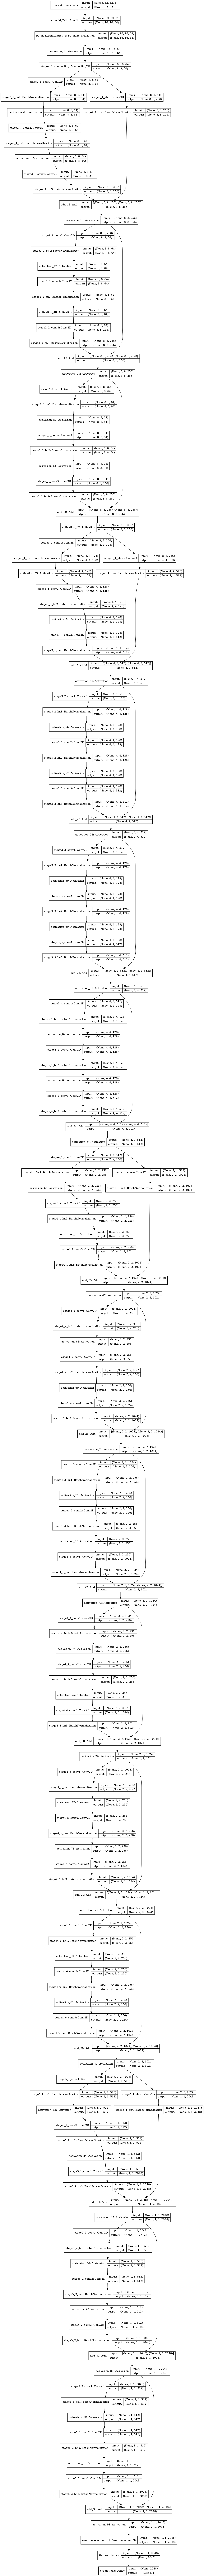

In [20]:
tf.keras.utils.plot_model(resnet_50,show_shapes=True)

In [21]:
resnet_p50 = build_resnet(input_shape=(32,32,3), is_50=True, is_plain=True)
resnet_p50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7x7 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_92 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 64)          4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 8, 8, 64)          256 

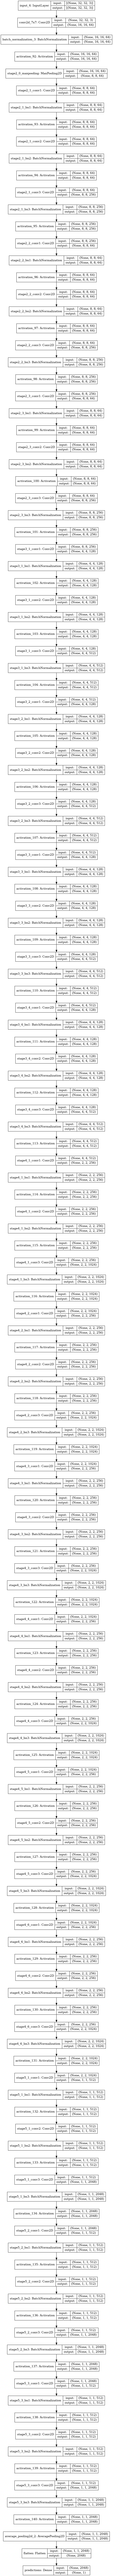

In [22]:
tf.keras.utils.plot_model(resnet_p50,show_shapes=True)

ResNet-50은 구현마다 약간씩 다르게 나올 수 있습니다. 왜냐하면 Residual 블록의 Batch Normalization과 ReLU 레이어의 위치가 논문에 명시되지 않았기 때문이죠!

하지만 ResNet을 고안한 4인방은 이에 대해 또 한번 논문을 씁니다. Residual 블록에 대해서 자세하게 씁니다. 이 논문을 읽어보면 오리지널 ResNet-50에 대한 힌트가 약.간. 있을 수도 있습니다~!

[resnet](https://arxiv.org/pdf/1603.05027.pdf)

### 3) 일반 네트워크(plain network) 만들기
블록 코드 수정하기

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!
전체 함수 코드 수정하기

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
Ablation Study

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.
시각화

학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.
추가 실험

시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.

[datasets](https://www.tensorflow.org/datasets/catalog/overview)

! mkdir -p ~/aiffel/ResNet_Ablation_Study   
! wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip   
! mv kagglecatsanddogs_3367a.zip ~/aiffel/ResNet_Ablation_Study   
! cd ~/aiffel/ResNet_Ablation_Study && unzip kagglecatsanddogs_3367a.zip


In [23]:
resnet_34 = build_resnet( input_shape=(224,224,3),is_50=False)
resnet_50 = build_resnet( input_shape=(224,224,3),is_50=True)
resnet_p34 = build_resnet(input_shape=(224,224,3),is_plain=True, is_50=False)
resnet_p50 = build_resnet(input_shape=(224,224,3),is_plain=True, is_50=True)

In [24]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 359s 284ms/step - loss: 0.9216 - accuracy: 0.5544 - val_loss: 1.1297 - val_accuracy: 0.5455
Epoch 2/10
1163/1163 [==============================] - 304s 261ms/step - loss: 0.8268 - accuracy: 0.5900 - val_loss: 0.9378 - val_accuracy: 0.6245
Epoch 3/10
1163/1163 [==============================] - 303s 261ms/step - loss: 0.7800 - accuracy: 0.6237 - val_loss: 1.4021 - val_accuracy: 0.5712
Epoch 4/10
1163/1163 [==============================] - 304s 261ms/step - loss: 0.6982 - accuracy: 0.6660 - val_loss: 0.7321 - val_accuracy: 0.6661
Epoch 5/10
1163/1163 [==============================] - 303s 261ms/step - loss: 0.6232 - accuracy: 0.7086 - val_loss: 0.8188 - val_accuracy: 0.6562
Epoch 6/10
1163/1163 [==============================] - 303s 261ms/step - loss: 0.5376 - accuracy: 0.7520 - val_loss: 1.0886 - val_accuracy: 0.6537
Epoch 7/10
1163/1163 [==============================] - 303s 261ms/step - loss: 0.4506 - accuracy: 0.7986 - val_

In [25]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 575s 457ms/step - loss: 1.0842 - accuracy: 0.5183 - val_loss: 1.7010 - val_accuracy: 0.5479
Epoch 2/10
1163/1163 [==============================] - 489s 421ms/step - loss: 0.9935 - accuracy: 0.5426 - val_loss: 2.4710 - val_accuracy: 0.5084
Epoch 3/10
1163/1163 [==============================] - 490s 421ms/step - loss: 1.0143 - accuracy: 0.5402 - val_loss: 1.8482 - val_accuracy: 0.5526
Epoch 4/10
1163/1163 [==============================] - 489s 420ms/step - loss: 0.9721 - accuracy: 0.5604 - val_loss: 1.5579 - val_accuracy: 0.5455
Epoch 5/10
1163/1163 [==============================] - 488s 420ms/step - loss: 0.9423 - accuracy: 0.5765 - val_loss: 1.7165 - val_accuracy: 0.5642
Epoch 6/10
1163/1163 [==============================] - 490s 421ms/step - loss: 0.9321 - accuracy: 0.5776 - val_loss: 3.5994 - val_accuracy: 0.5563
Epoch 7/10
1163/1163 [==============================] - 489s 421ms/step - loss: 0.8994 - accuracy: 0.6058 - val_

In [26]:
resnet_p34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p34 = resnet_p34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 301s 250ms/step - loss: 0.7796 - accuracy: 0.5044 - val_loss: 0.9652 - val_accuracy: 0.5403
Epoch 2/10
1163/1163 [==============================] - 289s 248ms/step - loss: 0.7656 - accuracy: 0.5238 - val_loss: 1.8965 - val_accuracy: 0.5414
Epoch 3/10
1163/1163 [==============================] - 289s 248ms/step - loss: 0.7602 - accuracy: 0.5307 - val_loss: 0.7644 - val_accuracy: 0.5352
Epoch 4/10
1163/1163 [==============================] - 289s 248ms/step - loss: 0.7590 - accuracy: 0.5262 - val_loss: 0.7858 - val_accuracy: 0.5371
Epoch 5/10
1163/1163 [==============================] - 288s 248ms/step - loss: 0.7428 - accuracy: 0.5330 - val_loss: 0.8100 - val_accuracy: 0.5559
Epoch 6/10
1163/1163 [==============================] - 288s 248ms/step - loss: 0.7224 - accuracy: 0.5577 - val_loss: 0.8659 - val_accuracy: 0.6012
Epoch 7/10
1163/1163 [==============================] - 288s 248ms/step - loss: 0.7094 - accuracy: 0.5956 - val_

In [27]:
resnet_p50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p50 = resnet_p50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 439s 366ms/step - loss: 0.7946 - accuracy: 0.5202 - val_loss: 7.0426 - val_accuracy: 0.4905
Epoch 2/10
1163/1163 [==============================] - 424s 365ms/step - loss: 0.7997 - accuracy: 0.5232 - val_loss: 2.1397 - val_accuracy: 0.5343
Epoch 3/10
1163/1163 [==============================] - 424s 364ms/step - loss: 0.8041 - accuracy: 0.5109 - val_loss: 1.7766 - val_accuracy: 0.5121
Epoch 4/10
1163/1163 [==============================] - 424s 364ms/step - loss: 0.8137 - accuracy: 0.5072 - val_loss: 1.0374 - val_accuracy: 0.5250
Epoch 5/10
1163/1163 [==============================] - 424s 364ms/step - loss: 0.8205 - accuracy: 0.5123 - val_loss: 1.0092 - val_accuracy: 0.4866
Epoch 6/10
1163/1163 [==============================] - 424s 364ms/step - loss: 0.8140 - accuracy: 0.5104 - val_loss: 1.4298 - val_accuracy: 0.5282
Epoch 7/10
1163/1163 [==============================] - 423s 364ms/step - loss: 0.8168 - accuracy: 0.5065 - val_

#### 검증 손실(val_loss)

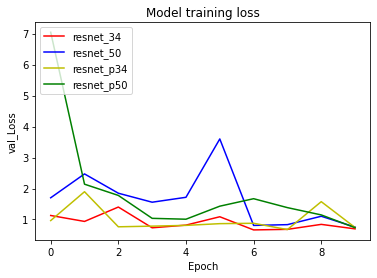

In [31]:
import matplotlib.pyplot as plt

plt.plot(history_34.history[ 'val_loss'], 'r')
plt.plot(history_50.history[ 'val_loss'], 'b')
plt.plot(history_p34.history['val_loss'], 'y')
plt.plot(history_p50.history['val_loss'], 'g')
plt.title('Model training loss')
plt.ylabel('val_Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50','resnet_p34', 'resnet_p50'], loc='upper left')
plt.show()

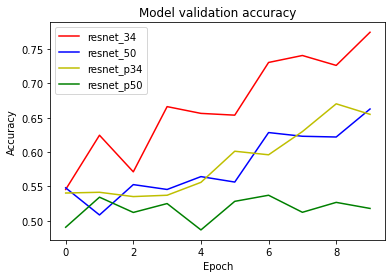

In [29]:
#검증 정확도(validation accuracy)
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_p34.history['val_accuracy'], 'y')
plt.plot(history_p50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50','resnet_p34', 'resnet_p50'], loc='upper left')
plt.show()

## 결과
- plain으로 x값을 참조하지 않은(레지듀얼블럭을 사용하지 않은) p34와 p50은 같은 에폭에서 같은 모델보다 확연히 낮은 결과를 보였다 
- 따라서 Ablation Study로 레지듀얼 블럭의 사용 여부는 성능에 상당한 영향을 끼친다.
- 의외인 점은 레즈넷 34의 결과가 50보다 좋았던 점이다. 다른 사람들과 상의해본 결과 대부분 레즈넷 50이 나쁜 비슷한 결과가 나왔으며   
    너무 깊어서 단순 식별 모델에서는 오히려 안좋았다는 결론을 내렸다.



## <center>Ablation Study 결과표(10epoch)</center>

모델명|Val_acc
:-|:-
ResNet-34|0.7744
ResNet-50|0.6626
plain-34|0.6549
plain-50|0.5179

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

No.|평가문항|	상세기준
-|:-|:-
1.| ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|	블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2.| 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|	cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3.| Ablation Study 결과가 바른 포맷으로 제출되었는가?|	ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

## 회고
- 개 고양이라 클래스가 2개일줄 알았는데 개 0,1 고양이 0,1이라 1로 구분해야 된다
- 배치사이즈가 높으면 요상한 에러가 났다 배치사이즈와 에러의 상관관계를 모르겠다
